### T-Period Consumption-Saving Model with Labor Supply

Solves a $T$-period consumption-saving model with endogenous labor supply and no uncertainty.

At each period $ t = 1, \dots, T $, the agent chooses consumption  $c_t$ and labor supply $\ell_t \in [0, 1] $ to maximize lifetime utility, trading off consumption gains with labor disutility:

$$
\begin{align}
V_t(a_t) &= \max_{c_t > 0, \; \ell_t \in [0,1]} \left\{ \frac{c_t^{1-\rho}}{1-\rho} + \varphi \cdot \frac{\ell_t^{1-\eta}}{1-\eta} + \beta \cdot V_{t+1}(a_{t+1}) \right\} \\
\text{s.t.} \quad a_{t+1} &= (1 + r).a_t + w_t \cdot (1-\ell_t) - c_t \\
a_t &\geq 0 \quad \text{(No borrowing)}
\end{align}
$$
### Model Parameter Settings

| **Parameter**   | **Value**                             | **Description**                             |
|------------------|-----------------------------------------|---------------------------------------------|
| `T`              | 50                                      | Number of periods                           |
| `β` (`beta`)     | 0.97                                    | Discount factor                             |
| `ρ` (`rho`)      | 1.5                                     | Relative risk aversion (CRRA)               |
| `ϕ` (`ϕ`)        | 0.04                                  | Weight on utility of leisure                |
| `η` (`eta`)      | 5.0                                     | Curvature parameter for leisure utility     |
| `w`              | 100,000                                  | Constant wage rate                          |
| `r`              | 0.03                                    | Interest rate                               |
| `a_max`          | 1,000,000                                 | Maximum assets in the grid                  |
| `Na`             | 25                                     | Number of asset grid points                 |
| `Nk`             | 25                                      | Number of labor supply grid points          |
| `k_grid`         | `nonlinspace(0.0, k_max, Nk, 1.1)`      | Labor supply from 0 (no work) to 1 (full)   |
| `a_grid`         | `nonlinspace(0.0, a_max, Na, 2.0)`      | Nonlinear asset grid (curved toward 0)      |

### Setup

In [118]:
using Random, NLopt, LinearAlgebra, Interpolations, Roots
using Plots, Statistics, ProgressMeter, ForwardDiff, Distributions

### Model

In [119]:
# -------------------------------
# Utility: Nonlinear Grid Creator
# -------------------------------
function nonlinspace(start::Float64, stop::Float64, num::Int, curv::Float64)
    lin_vals = range(0, stop=1, length=num)
    curved_vals = lin_vals .^ curv
    return start .+ (stop - start) .* curved_vals
end


function create_focused_grid(a_min::Float64, a_focus::Float64, a_max::Float64, Na::Int, focus_share::Float64, curv::Float64)
    # Number of points in the focus region (0 to 250,000)
    Na_focus = ceil(Int, Na * focus_share)
    # Number of points in the remaining region (250,000 to 1,000,000)
    Na_rest = Na - Na_focus
    
    # Create grid for the focus region
    grid_focus = nonlinspace(a_min, a_focus, Na_focus, curv)
    # Create grid for the upper region, excluding the duplicate point at a_focus
    grid_rest = nonlinspace(a_focus, a_max, Na_rest + 1, curv)[2:end]
    
    # Combine the two grids
    return vcat(grid_focus, grid_rest)
end


# -------------------------------
# Dynamic Labor Model Definition
# -------------------------------
mutable struct ConSavLabor
    T::Int                        # Time periods
    rho::Float64                 # Risk aversion (CRRA)
    beta::Float64                # Discount factor
    phi::Float64                 # Weight on labor disutility
    eta::Float64                 # Frisch elasticity parameter
    alpha::Float64               # (possibly productivity or returns to labor)
    w::Float64                   # Wage rate
    y::Float64                   # Non-labor income
    tau::Float64                 # Labor income tax
    r::Float64                   # Interest rate
    a_max::Float64               # Max asset level
    a_min::Float64               # Min asset level
    Na::Int                      # Number of asset grid points
    k_max::Float64               # Max labor effort
    Nk::Int                      # Number of labor grid points
    simT::Int                    # Simulation time periods
    simN::Int                    # Number of simulated agents
    a_grid::Vector{Float64}      # Asset grid
    k_grid::Vector{Float64}      # Labor grid
    sol_c::Array{Float64,3}      # Optimal consumption [T, Na, Nk]
    sol_h::Array{Float64,3}      # Optimal labor effort [T, Na, Nk]
    sol_v::Array{Float64,3}      # Value function [T, Na, Nk]
    sim_c::Array{Float64,2}      # Simulated consumption [simN, simT]
    sim_h::Array{Float64,2}      # Simulated labor [simN, simT]
    sim_a::Array{Float64,2}      # Simulated assets [simN, simT]
    sim_k::Array{Float64,2}      # Simulated labor choice [simN, simT]
    sim_a_init::Vector{Float64}  # Initial assets
    sim_k_init::Vector{Float64}  # Initial labor effort
    draws_uniform::Array{Float64,2}  # Uniform draws for simulation [simN, simT]
    w_vec::Vector{Float64}       # Time-varying wage vector [T]
end

# -------------------------------
# Constructor for ConSavLabor
# -------------------------------
function ConSavLabor(; T::Int=50, beta::Float64=0.97, rho::Float64=1.5, y::Float64=30000.0,
                           r::Float64=0.03, a_max::Float64=1000000.0, Na::Int=25, simN::Int=5000,
                           a_min::Float64=0.0, k_max::Float64=15.0, Nk::Int=25,
                           w::Float64=100000.0, tau::Float64=0.25,
                           eta::Float64=5.0, alpha::Float64=0.08,
                           phi::Float64=0.04, seed::Int=1234)

    # --- Time horizon and simulation settings ---
    simT = T

    # --- Grids for state variables and decisions ---
    #a_grid = nonlinspace(a_min, a_max, Na, 1.5)
    a_grid = create_focused_grid(a_min, 500000.0, a_max, Na, 0.9, 1.1)
    k_grid = nonlinspace(0.0, k_max, Nk, 1.5)


    # --- Storage for solution (policy + value functions) ---
    # Dimensions: (T, Na, Nk) 
    sol_shape = (T, Na, Nk)
    sol_c = fill(NaN, sol_shape)   # Optimal consumption
    sol_h = fill(NaN, sol_shape)   # Optimal labor effort
    sol_v = fill(NaN, sol_shape)   # Value function

    # --- Simulation storage ---
    sim_shape = (simN, simT)
    sim_c = fill(NaN, sim_shape)
    sim_h = fill(NaN, sim_shape)
    sim_a = fill(NaN, sim_shape)
    sim_k = fill(NaN, sim_shape)

    # --- Random draws for simulation ---
    rng = MersenneTwister(seed)
    draws_uniform = rand(rng, sim_shape...)

    # --- Initial conditions for simulation ---
    sim_a_init = zeros(Float64, simN)
    sim_k_init = zeros(Float64, simN)

    # --- Wage vector (can vary by time) ---
    w_vec = fill(w, T)

    # --- Return constructed model ---
    return ConSavLabor(T, rho, beta, phi, eta, alpha, w, y, tau, r,
                          a_max, a_min, Na, k_max, Nk, simT, simN,
                          a_grid, k_grid,
                          sol_c, sol_h, sol_v,
                          sim_c, sim_h, sim_a, sim_k,
                          sim_a_init, sim_k_init, draws_uniform, w_vec)
end


ConSavLabor

In [120]:
# --------------------------
# Model Solver
# --------------------------


function solve_model!(model::ConSavLabor)
    T, Na, Nk = model.T, model.Na, model.Nk
    a_grid, k_grid = model.a_grid, model.k_grid
    sol_c, sol_h, sol_v = model.sol_c, model.sol_h, model.sol_v

    # --- Final period (t = T) ---
    for i_a in 1:Na
        for i_k in 1:Nk
            assets = a_grid[i_a]
            capital = k_grid[i_k]
            function obj_last(h_vec::Vector, grad::Vector)
                return obj_last_period(model, h_vec[1], assets, capital, T)
            end
            opt = Opt(:LN_BOBYQA, 1)
            lower_bounds!(opt, [0.0])
            upper_bounds!(opt, [1.0])
            ftol_rel!(opt, 1e-6)  # Tightened tolerance
            min_objective!(opt, obj_last)
            init = [0.5]
            (minf, h_vec, ret) = optimize(opt, init)
            h_opt = h_vec[1]
            cons = assets + wage_func(model, capital, T) * h_opt
            sol_h[T, i_a, i_k] = h_opt
            sol_c[T, i_a, i_k] = cons
            sol_v[T, i_a, i_k] = -minf
        end
    end

    # --- Earlier periods (t = T-1 to 1) ---
    @showprogress 1 "Solving working model..." for t in (T-1):-1:1
        interp = create_interp(model, sol_v, t + 1)
        for i_a in 1:Na
            for i_k in 1:Nk
                assets = a_grid[i_a]
                capital = k_grid[i_k]
                w = wage_func(model, capital, t)
                function obj_work(x::Vector, grad::Vector)
                    c, h = x[1], x[2]
                    return -value_of_work_choice(model, c, h, assets, capital, t, interp)
                end
                opt = Opt(:LN_BOBYQA, 2)
                lower_bounds!(opt, [1e-6, 0.0])
                upper_bounds!(opt, [Inf, 1.0])
                ftol_rel!(opt, 1e-6)  # Tightened tolerance
                min_objective!(opt, obj_work)
                init = [sol_c[t + 1, i_a, i_k], sol_h[t + 1, i_a, i_k]]          # Previous solution
                #init = [sol_c[t + 1, i_a, i_k] * 0.5, sol_h[t + 1, i_a, i_k] * 0.5]  # Lower guess
                #init = [sol_c[t + 1, i_a, i_k] * 1.5, sol_h[t + 1, i_a, i_k] * 1.5]  # Higher guess
                # Optimize with each initial guess and select the solution with the highest objective value
                (minf, x_opt, ret) = optimize(opt, init)
                sol_c[t, i_a, i_k] = x_opt[1]
                sol_h[t, i_a, i_k] = x_opt[2]
                sol_v[t, i_a, i_k] = -minf
            end
        end
    end

    return model
end

function value_of_work_choice(model::ConSavLabor, c::Float64, h::Float64, assets::Float64,
    capital::Float64, t::Int, interp)
    penalty_c = c < 0.0 ? (abs(c)^2) * 1.0e7 : 0.0
    penalty_h = h < 0.0 ? (abs(h)^2) * 10e6 : 0.0
    income = wage_func(model, capital, t) * h
    a_next = (1.0 + model.r) * assets + income - c
    penalty_a = a_next < model.a_min ? ((model.a_min - a_next)^2) * 1.0e10 : 0.0
    util_now = util(model, c, h)
    k_next = capital + h
    V_next = interp(a_next, k_next)
    return util_now + model.beta * V_next - penalty_c - penalty_h - penalty_a
end

# ------------------------------------------------
# Supporting functions 
# ------------------------------------------------


@inline function obj_last_period(model::ConSavLabor, h::Float64, assets::Float64, capital::Float64, t::Int)
    income = wage_func(model, capital, t) * h
    cons = assets + income  # Consume all resources
    u = util(model, cons, h)
    return -u  # Minimize negative utility
end

@inline function util(model::ConSavLabor, c, h)
    # Utility from consumption and utility from leisure.
    # Note: we use par.phi (the weight on labor disutility) in place of a kids-adjusted parameter.
    par = model
    l = 1-h
    return (c^(1.0 - par.rho))/(1.0 - par.rho) + par.phi*(l^(1.0 - par.eta))/(1.0 - par.eta)
end

@inline function wage_func(model::ConSavLabor, capital::Float64, t::Int)
    # Compute the effective wage: after tax wage rate adjusted for capital effects.
    par = model  # Extract model parameters
    return (1.0 - par.tau) * par.w_vec[t] * (1.0 + par.alpha * capital)
end



# Interpolation helper function
function create_interp(model::ConSavLabor, sol_v::Array{Float64, 3}, t::Int)
    return LinearInterpolation((model.a_grid, model.k_grid), sol_v[t, :, :], extrapolation_bc=Line())
end


# --------------------------
# Simulation
# --------------------------
# Simulate consumption and asset paths based on the solved policy functions

function simulate_model!(model::ConSavLabor)
    simN, simT = model.simN, model.simT
    sim_a, sim_k = model.sim_a, model.sim_k
    sim_c, sim_h = model.sim_c, model.sim_h
    draws_uniform = model.draws_uniform

    # Precompute interpolation objects for each period.
    # sol_c and sol_h are assumed to be 3D arrays: dimensions (T, Na, Nk)
    interp_dict = Dict()
    for t in 1:simT
        sol_c_slice = model.sol_c[t, :, :]
        sol_h_slice = model.sol_h[t, :, :]
        interp_dict[(t, :c)] = LinearInterpolation((model.a_grid, model.k_grid), sol_c_slice, extrapolation_bc=Line())
        interp_dict[(t, :h)] = LinearInterpolation((model.a_grid, model.k_grid), sol_h_slice, extrapolation_bc=Line())
    end

    # Initialize simulation with initial asset and capital conditions.
    for i in 1:simN
        sim_a[i, 1] = model.sim_a_init[i]
        sim_k[i, 1] = model.sim_k_init[i]
    end

    # Simulation loop.
    for i in 1:simN
        for t in 1:simT
            sim_c[i, t] = interp_dict[(t, :c)](sim_a[i, t], sim_k[i, t])
            sim_h[i, t] = interp_dict[(t, :h)](sim_a[i, t], sim_k[i, t])
            # Ensure hours stay in [0, 1].
            sim_h[i, t] = clamp(sim_h[i, t], 0.0, 1.0)
            if t < simT
                income = wage_func(model, sim_k[i, t], t) * sim_h[i, t]
                sim_a[i, t+1] = (1 + model.r) * (sim_a[i, t]) + income - sim_c[i, t]
                sim_k[i, t+1] = sim_k[i, t] + sim_h[i, t]
            end
        end
    end
end




simulate_model! (generic function with 1 method)

### Model and Counterfactual Simulation in a T-Period 
This script solves and simulates a finite-horizon (T-period) consumption-saving model under different economic scenarios. It compares a baseline model with four counterfactual experiments, focusing on how each setting affects average consumption and asset accumulation over time.


In [121]:
# ============================
# Baseline and Counterfactuals
# ============================

# -- Baseline Model (Default Parameters) --
model_baseline = ConSavLabor(Na=25)
solve_model!(model_baseline)
simulate_model!(model_baseline)

# ----------------------------------------
# Counterfactual 1: Tax Rate Variations
# ----------------------------------------

# Lower tax rate (τ = 10%)
model_low_tax = ConSavLabor(tau = 0.10)
solve_model!(model_low_tax)
simulate_model!(model_low_tax)

# Higher tax rate (τ = 30%)
model_high_tax = ConSavLabor(tau = 0.30)
solve_model!(model_high_tax)
simulate_model!(model_high_tax)

# ----------------------------------------
# Counterfactual 2: Wage Variations
# ----------------------------------------

# Higher wage level (w = 150,000)
model_high_wage = ConSavLabor(w = 150000.0)
solve_model!(model_high_wage)
simulate_model!(model_high_wage)

# ----------------------------------------
# Counterfactual 3: Time Preference (Discount Factor β)
# ----------------------------------------

# More impatient agent (β = 0.96)
model_low_beta = ConSavLabor(beta = 0.96)
solve_model!(model_low_beta)
simulate_model!(model_low_beta)

# More patient agent (β = 0.98)
model_high_beta = ConSavLabor(beta = 0.98)
solve_model!(model_high_beta)
simulate_model!(model_high_beta)

# ----------------------------------------
# Counterfactual 4: Frisch Elasticity (η)
# ----------------------------------------

# Higher Frisch elasticity (η = 3.0 → more responsive labor supply)
model_high_fe = ConSavLabor(eta = 3.0)
solve_model!(model_high_fe)
simulate_model!(model_high_fe)

# Lower Frisch elasticity (η = 7.0 → less responsive labor supply)
model_low_fe = ConSavLabor(eta = 7.0)
solve_model!(model_low_fe)
simulate_model!(model_low_fe)

# ----------------------------------------
# Counterfactual 5: Initial Assets from Lognormal Distribution
# ----------------------------------------

# Assign initial assets from a LogNormal distribution with ~90% falling between $5k and $20k
μ = 9.4
σ = 0.45

model_lognormal = ConSavLabor()
model_lognormal.sim_a_init .= rand(LogNormal(μ, σ), model_lognormal.simN)
solve_model!(model_lognormal)
simulate_model!(model_lognormal)

# ----------------------------------------
# Counterfactual 6: Retirement Income Reduction
# ----------------------------------------

# Assume wage = 0.7*w after period 40 (e.g., partial retirement)
model_retirement = ConSavLabor()
model_retirement.w_vec[1:40] .= model_retirement.w
model_retirement.w_vec[40:end] .= 0.7 * model_retirement.w
solve_model!(model_retirement)
simulate_model!(model_retirement)

# ----------------------------------------
# Counterfactual 7: Interest Rate Variations (r)
# ----------------------------------------

# Lower interest rate (r = 1%)
model_low_r = ConSavLabor(r = 0.01)
solve_model!(model_low_r)
simulate_model!(model_low_r)

# Higher interest rate (r = 5%)
model_high_r = ConSavLabor(r = 0.05)
solve_model!(model_high_r)
simulate_model!(model_high_r)

### Model Structure and Policy Function Visualization

- **Asset Grid (Top-left):**  
  Displays the nonlinear asset grid, with denser points at low asset levels.

- **Terminal Value Function (Top-right):**  
Depicts the value function at \(T = 50\), representing lifetime utility as a function of assets.

- **Terminal Consumption Policy (Middle-left):**  
  Shows optimal consumption at the terminal period (\(T = 50\)), where agents consume all available resources.

- **Early Consumption Policy (Middle-right):**  
  Illustrates optimal consumption at an earlier period (\(T = 10\)), reflecting saving behavior.

- **Early Labor Policy (Bottom-left):**  
  Displays optimal labor supply at \(T = 10\).

- **Terminal Labor Policy (Bottom-right):**  
  Shows optimal labor supply at \(T = 50\).

This layout clarifies how the asset grid design and time dynamics shape optimal consumption and labor decisions.

In [122]:

# Choose a representative labor grid index (e.g. the median)
k_mid = Int(ceil(length(model_baseline.k_grid)/2))
T_terminal = model_baseline.T  # Terminal period (e.g., 50)
t_early = 10          # An earlier period for comparison

# 1. Plot the nonlinear asset grid
p1 = scatter(1:length(model_baseline.a_grid), model_baseline.a_grid,
    xlabel = "Grid Index",
    ylabel = "Asset Level",
    title = "Nonlinear Asset Grid",
    legend = false,
    markersize = 3)

# 2. Plot optimal consumption policy at terminal period (T = model.T)
# Here we fix the labor dimension at k_mid.
p2 = scatter(model_baseline.a_grid, model_baseline.sol_c[T_terminal, :, k_mid],
    xlabel = "Assets",
    ylabel = "Consumption",
    title = "Optimal Consumption (T = $(T_terminal))",
    label = "cₜ(a)",
    markersize = 3)

# 3. Plot value function at terminal period (T = model.T)
# Note: use 'sol_v' (not sol_V) as per your definition.
p3 = plot(model_baseline.a_grid, model_baseline.sol_v[T_terminal, :, k_mid],
    xlabel = "Assets",
    ylabel = "Value",
    title = "Value Function (T = $(T_terminal))",
    label = "Vₜ(a)",
    linewidth = 2)

# 4. Plot optimal consumption policy at an earlier period (e.g., T = 10)
p4 = scatter(model_baseline.a_grid, model_baseline.sol_c[t_early, :, k_mid],
    xlabel = "Assets",
    ylabel = "Consumption",
    title = "Optimal Consumption (T = $(t_early))",
    label = "cₜ(a)",
    markersize = 3)

p5 = scatter(model_baseline.a_grid, model_baseline.sol_h[t_early, :, k_mid],
    xlabel = "Assets",
    ylabel = "Labor",
    title = "Optimal Labor (T = $(t_early))",
    label = "hₜ(a)",
    markersize = 3)

p6 = scatter(model_baseline.a_grid, model_baseline.sol_h[T_terminal, :, k_mid],
    xlabel = "Assets",
    ylabel = "Labor",
    title = "Optimal Labor (T = $(T_terminal))",
    label = "hₜ(a)",
    markersize = 3)

# Combine all plots into a 2×2 grid layout for comparison
plot(p1, p3, p2, p4, p6, p5, layout = (3, 2), size = (1200, 1200), margin=3mm)

LoadError: UndefVarError: `mm` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing Measures in the current active module Main

###  Counterfactual Analysis
We investigate the effects of key economic parameters on individual consumption, savings, labor effort, and human capital accumulation. Our **baseline model** is defined as follows:


In [ ]:
t = 1:model_baseline.simT

# Helper function to compute average path over agents
function avg_sim(var)
    return vec(mean(var, dims=1))
end

# Extract averages for all simulated variables
function extract_all(model)
    return (
        c = avg_sim(model.sim_c),
        a = avg_sim(model.sim_a),
        h = avg_sim(model.sim_h),
        k = avg_sim(model.sim_k)
    )
end


extract_all (generic function with 1 method)

##### Counterfactual 1: **Tax Rate Variations**

We vary the labor income tax rate to examine its impact on work incentives and savings behavior.

- **Baseline:** τ = 0.25
- **Low Tax:** τ = 0.10
- **High Tax:** τ = 0.30 

> 💡 **Interpretation:**  
> Lower taxes increase disposable income, which leads to higher consumption and more asset accumulation. Higher taxes reduce both, while increasing labor disincentives.


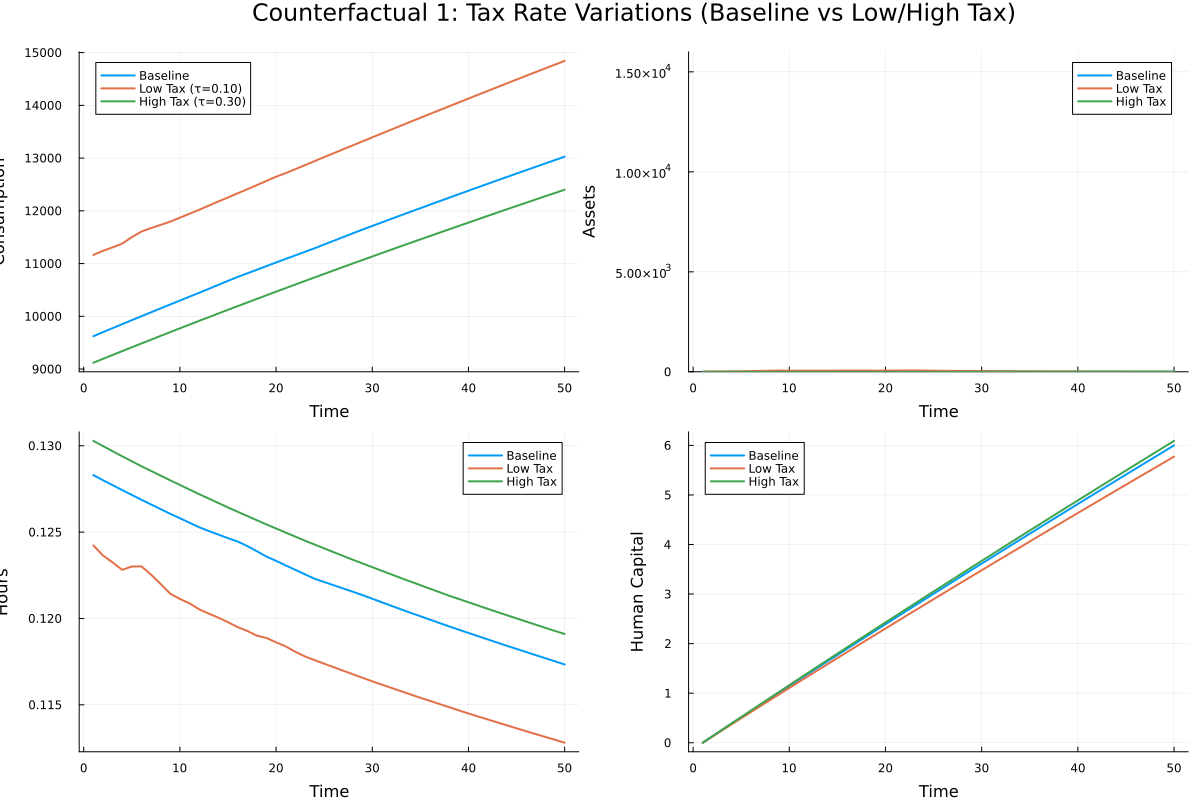

In [ ]:
# ----------------------------------------------
# 1. Tax Rate Variations (Low and High Tax)
# ----------------------------------------------
# Baseline averages
base = extract_all(model_baseline);
low_tax = extract_all(model_low_tax)
high_tax = extract_all(model_high_tax)

p1 = plot(t, base.c, label="Baseline", lw=2, xlabel="Time", ylabel="Consumption")
plot!(t, low_tax.c, label="Low Tax (τ=0.10)", lw=2)
plot!(t, high_tax.c, label="High Tax (τ=0.30)", lw=2)

p2 = plot(t, base.a, label="Baseline", lw=2, xlabel="Time", ylabel="Assets", ylims=(0, 16000))
plot!(t, low_tax.a, label="Low Tax", lw=2)
plot!(t, high_tax.a, label="High Tax", lw=2)

p3 = plot(t, base.h, label="Baseline", lw=2, xlabel="Time", ylabel="Hours")
plot!(t, low_tax.h, label="Low Tax", lw=2)
plot!(t, high_tax.h, label="High Tax", lw=2)

p4 = plot(t, base.k, label="Baseline", lw=2, xlabel="Time", ylabel="Human Capital")
plot!(t, low_tax.k, label="Low Tax", lw=2)
plot!(t, high_tax.k, label="High Tax", lw=2)

# Combine and add ONE title
plot(p1, p2, p3, p4,
     layout = (2, 2),
     size = (1200, 800),
     plot_title = "Counterfactual 1: Tax Rate Variations (Baseline vs Low/High Tax)",
     titlefont = 16, margin=3mm)

##### Counterfactual 2: **Wage Variations**

We increase the wage rate to study the response in labor effort, income, and savings.

- **Baseline:** w = 100,000  
- **High Wage:** w = 150,000  

> 💡 **Interpretation:**  
> A higher wage raises labor income and thus consumption and wealth, with little change in hours worked due to offsetting income and substitution effects.


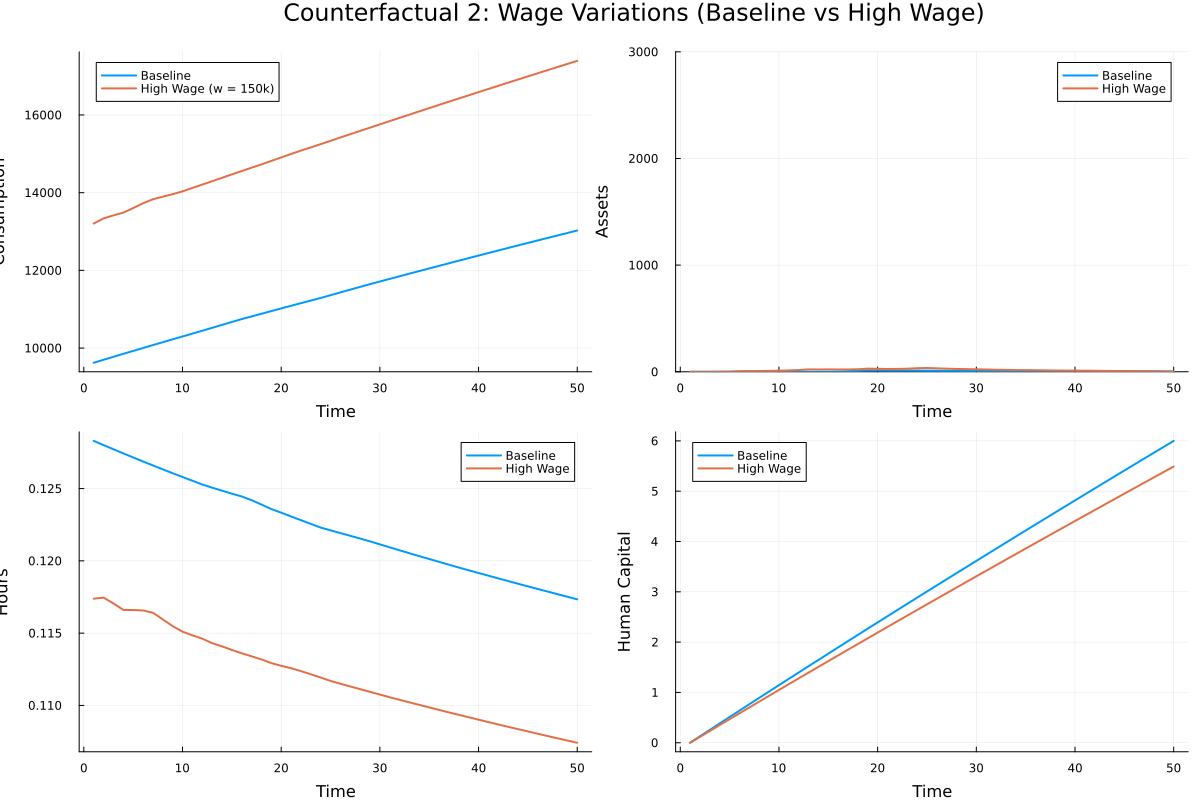

In [ ]:
# ----------------------------------------------
# 2. Wage Variations (Baseline vs High Wage)
# ----------------------------------------------
high_wage = extract_all(model_high_wage)

p5 = plot(t, base.c, label="Baseline", lw=2, xlabel="Time", ylabel="Consumption")
plot!(t, high_wage.c, label="High Wage (w = 150k)", lw=2)

p6 = plot(t, base.a, label="Baseline", lw=2, xlabel="Time", ylabel="Assets", ylims = [0,3000])
plot!(t, high_wage.a, label="High Wage", lw=2)

p7 = plot(t, base.h, label="Baseline", lw=2, xlabel="Time", ylabel="Hours")
plot!(t, high_wage.h, label="High Wage", lw=2)

p8 = plot(t, base.k, label="Baseline", lw=2, xlabel="Time", ylabel="Human Capital")
plot!(t, high_wage.k, label="High Wage", lw=2)

plot(p5, p6, p7, p8,
     layout = (2, 2),
     size = (1200, 800),
     plot_title = "Counterfactual 2: Wage Variations (Baseline vs High Wage)",
     titlefont = 16, margin=3mm)

##### Counterfactual 3: **Discount Factor Variations (Time Preference)**

We vary the discount factor $ \beta $ to analyze how patience affects consumption, savings, and labor supply behavior over the life cycle.

- **Baseline:** $ \beta = 0.97 $  
- **Low Beta:** $ \beta = 0.96 $ (more impatient)  
- **High Beta:** $ \beta = 0.98 $ (more patient)

> 💡 **Interpretation:**  
> A **lower $\beta$** leads to more present-oriented behavior—individuals **consume more early on**, **save less**, and **work more** to fund current consumption.  
> A **higher $\beta$** implies stronger future orientation—people **defer consumption**, **save more**, and **may work less** due to greater accumulated wealth.



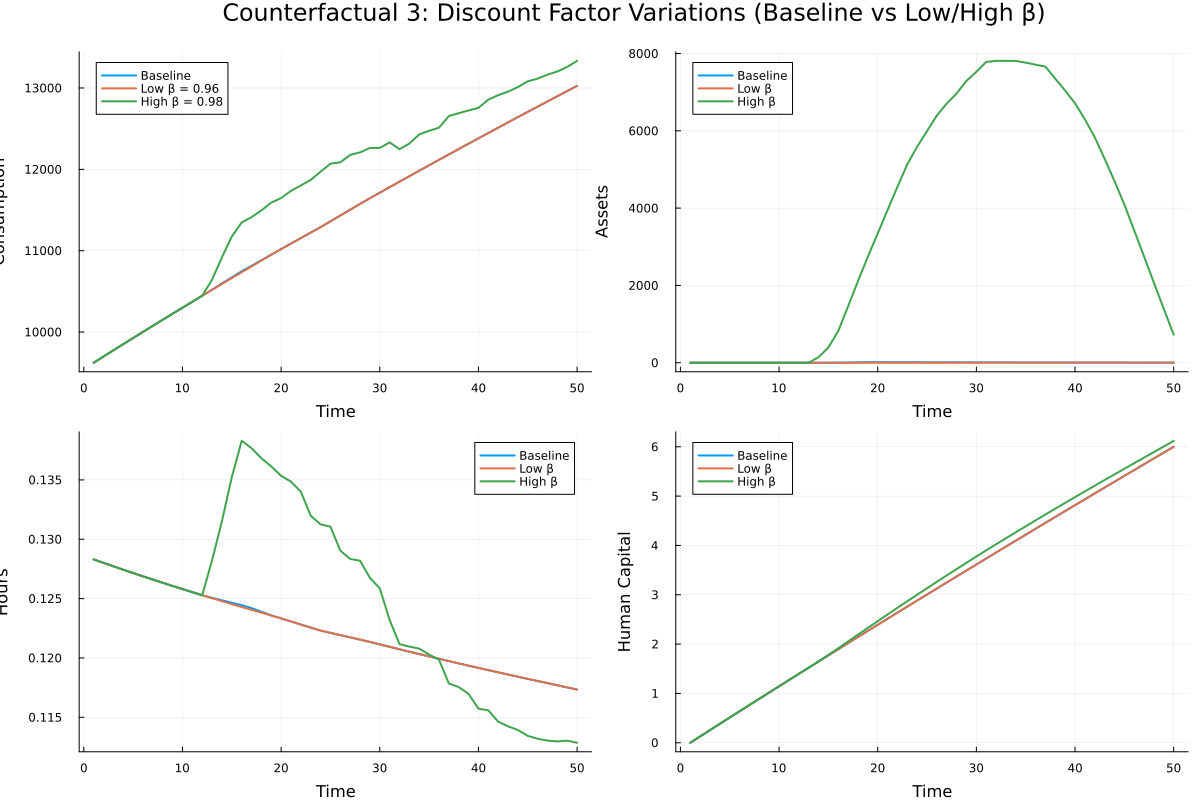

In [ ]:
# ----------------------------------------------
# 3. Discount Factor Variations (Low and High β)
# ----------------------------------------------

# Extract simulated series
low_beta  = extract_all(model_low_beta)
high_beta = extract_all(model_high_beta)

# Plot: Consumption
pβ1 = plot(t, base.c, label="Baseline", lw=2, xlabel="Time", ylabel="Consumption")
plot!(t, low_beta.c, label="Low β = 0.96", lw=2)
plot!(t, high_beta.c, label="High β = 0.98", lw=2)

# Plot: Assets
pβ2 = plot(t, base.a, label="Baseline", lw=2, xlabel="Time", ylabel="Assets")
plot!(t, low_beta.a, label="Low β", lw=2)
plot!(t, high_beta.a, label="High β", lw=2)

# Plot: Labor hours
pβ3 = plot(t, base.h, label="Baseline", lw=2, xlabel="Time", ylabel="Hours")
plot!(t, low_beta.h, label="Low β", lw=2)
plot!(t, high_beta.h, label="High β", lw=2)

# Plot: Capital
pβ4 = plot(t, base.k, label="Baseline", lw=2, xlabel="Time", ylabel="Human Capital")
plot!(t, low_beta.k, label="Low β", lw=2)
plot!(t, high_beta.k, label="High β", lw=2)

# Combine plots
plot(pβ1, pβ2, pβ3, pβ4,
     layout = (2, 2),
     size = (1200, 800),
     plot_title = "Counterfactual 3: Discount Factor Variations (Baseline vs Low/High β)",
     titlefont = 16, margin=3mm)

##### Counterfactual 4: **Frisch Elasticity**

We vary the elasticity of labor supply (η) and the disutility weight of working (φ).

- **Baseline:** η = 5.0
- **High Frisch Elasticity:** η = 3.0 
- **Low Frisch Elasticity:** η = 7.0

> 💡 **Interpretation:**  
> A lower η implies a more elastic labor supply—agents respond more to wage changes.


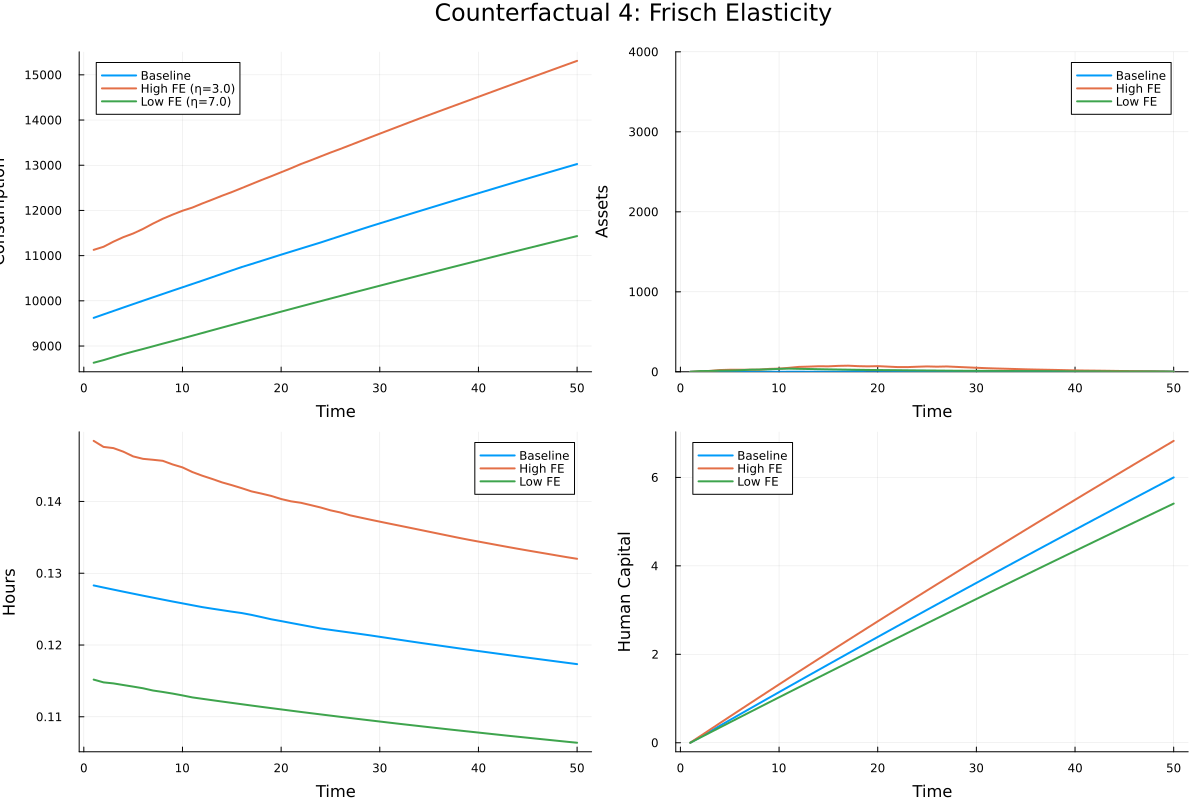

In [ ]:
# ----------------------------------------------
# 4. Frisch Elasticity 
# ----------------------------------------------
high_fe = extract_all(model_high_fe)
low_fe = extract_all(model_low_fe)

p9 = plot(t, base.c, label="Baseline", lw=2, xlabel="Time", ylabel="Consumption")
plot!(t, high_fe.c, label="High FE (η=3.0)", lw=2)
plot!(t, low_fe.c, label="Low FE (η=7.0)", lw=2)

p10 = plot(t, base.a, label="Baseline", lw=2, xlabel="Time", ylabel="Assets", ylims = [0,4000])
plot!(t, high_fe.a, label="High FE", lw=2)
plot!(t, low_fe.a, label="Low FE", lw=2)

p11 = plot(t, base.h, label="Baseline", lw=2, xlabel="Time", ylabel="Hours")
plot!(t, high_fe.h, label="High FE", lw=2)
plot!(t, low_fe.h, label="Low FE", lw=2)

p12 = plot(t, base.k, label="Baseline", lw=2, xlabel="Time", ylabel="Human Capital")
plot!(t, high_fe.k, label="High FE", lw=2)
plot!(t, low_fe.k, label="Low FE", lw=2)

plot(p9, p10, p11, p12,
     layout = (2, 2),
     size = (1200, 800),
     plot_title = "Counterfactual 4: Frisch Elasticity",
     titlefont = 16, margin=3mm)

##### Counterfactual 5: **Initial Asset Distribution**

We introduce heterogeneity in initial wealth by drawing from a lognormal distribution.

- **Baseline:** Initial assets = 0  
- **Counterfactual:** Initial assets ∼ LogNormal(μ = 9.4, σ = 0.45; ~90% to fall between 5,000 and 20,000)

> 💡 **Interpretation:**  
> Agents starting with more wealth consume more and work slightly less early in life. Their asset accumulation path is flatter compared to the baseline.

---


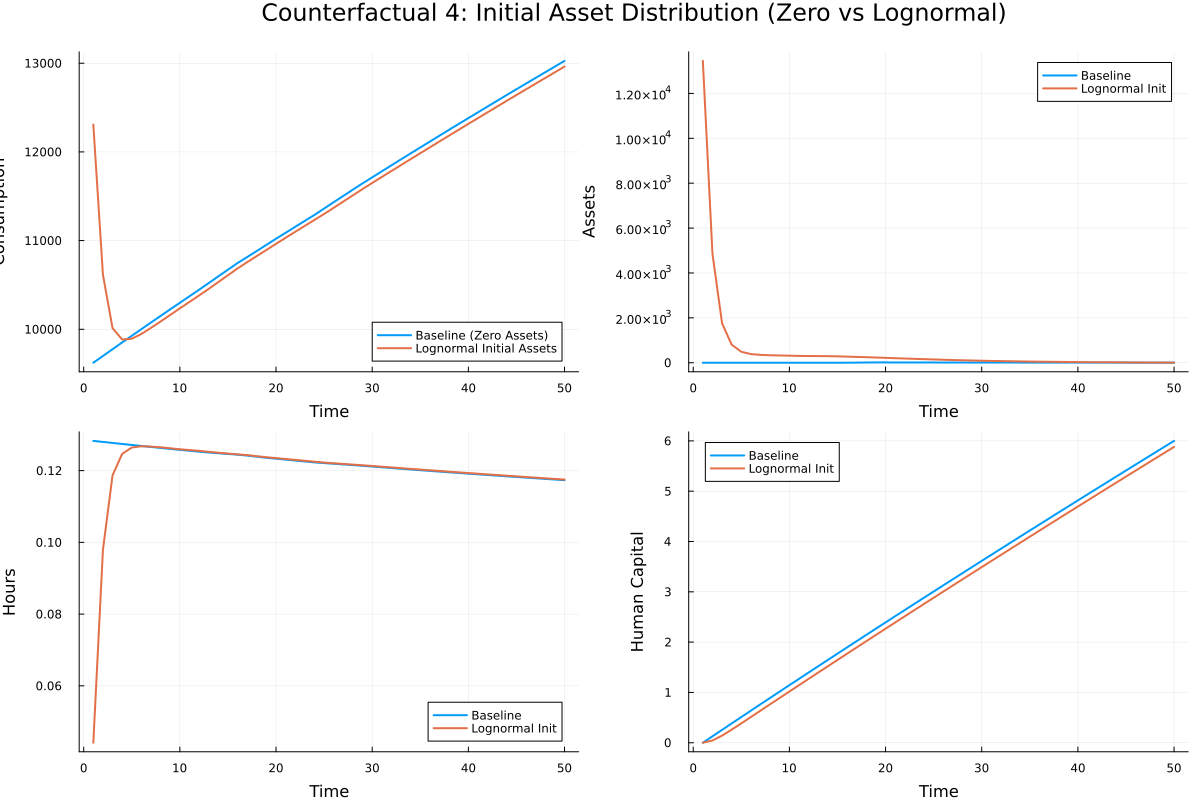

In [ ]:
# ----------------------------------------------
# 5. Initial Assets (Baseline vs Lognormal)
# ----------------------------------------------
lognorm = extract_all(model_lognormal)

p13 = plot(t, base.c, label="Baseline (Zero Assets)", lw=2, xlabel="Time", ylabel="Consumption")
plot!(t, lognorm.c, label="Lognormal Initial Assets", lw=2)

p14 = plot(t, base.a, label="Baseline", lw=2, xlabel="Time", ylabel="Assets")
plot!(t, lognorm.a, label="Lognormal Init", lw=2)

p15 = plot(t, base.h, label="Baseline", lw=2, xlabel="Time", ylabel="Hours")
plot!(t, lognorm.h, label="Lognormal Init", lw=2)

p16 = plot(t, base.k, label="Baseline", lw=2, xlabel="Time", ylabel="Human Capital")
plot!(t, lognorm.k, label="Lognormal Init", lw=2)

plot(p13, p14, p15, p16,
     layout = (2, 2),
     size = (1200, 800),
     plot_title = "Counterfactual 4: Initial Asset Distribution (Zero vs Lognormal)",
     titlefont = 16, margin=3mm)

##### Counterfactual 6: **Retirement Income Reduction**

We simulate a drop in labor income during the later stages of the life cycle to approximate retirement. Specifically, we assume that after period 40, wages fall to 70% of their original level.

- **Baseline:** Constant wage $ w $ throughout life  
- **Retirement Scenario:** $ w_t = 0.7w $ for $ t \geq 40 $

> 💡 **Interpretation:**  
> As wages decline post-retirement, individuals **reduce consumption**, **draw down savings**, and **work fewer hours** if feasible.  
> The model captures lifecycle behavior such as **asset decumulation** and **increased reliance on prior savings** to smooth consumption in retirement.

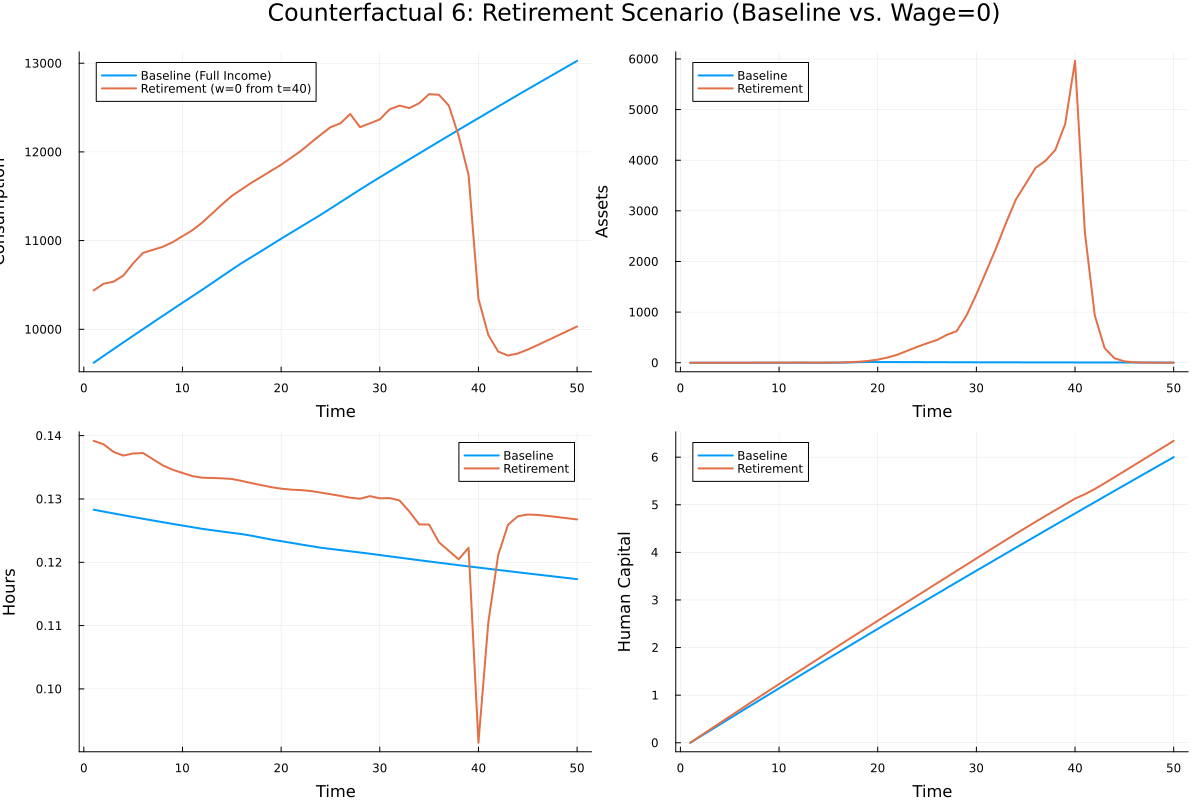

In [ ]:
# ----------------------------------------------
# 6. Retirement (Baseline vs Retirement)
# ----------------------------------------------


# Extract simulation data
base   = extract_all(model_baseline)     # Baseline simulation (full income every period)
retire = extract_all(model_retirement)    # Retirement simulation (wage drops to 0 from t = 40)

# Plot Consumption
p13 = plot(t, base.c, label="Baseline (Full Income)", lw=2, xlabel="Time", ylabel="Consumption")
plot!(p13, t, retire.c, label="Retirement (w=0 from t=40)", lw=2)

# Plot Assets
p14 = plot(t, base.a, label="Baseline", lw=2, xlabel="Time", ylabel="Assets")
plot!(p14, t, retire.a, label="Retirement", lw=2)

# Plot Hours
p15 = plot(t, base.h, label="Baseline", lw=2, xlabel="Time", ylabel="Hours")
plot!(p15, t, retire.h, label="Retirement", lw=2)

# Plot Capital
p16 = plot(t, base.k, label="Baseline", lw=2, xlabel="Time", ylabel="Human Capital")
plot!(p16, t, retire.k, label="Retirement", lw=2)

# Arrange the four plots in a 2x2 grid with a common title and increased size.
plot(p13, p14, p15, p16,
     layout = (2, 2),
     size = (1200, 800),
     plot_title = "Counterfactual 6: Retirement Scenario (Baseline vs. Wage=0)",
     titlefont = 16, margin=3mm)

##### Counterfactual 7: **Interest Rate Variations**

We alter the interest rate $ r $ to understand how the return on savings influences household decisions.

- **Baseline:** $ r = 3\% $  
- **Low r:** $ r = 1\% $  
- **High r:** $ r = 5\% $

> 💡 **Interpretation:**  
> A **higher interest rate** increases the return on saving, encouraging **greater asset accumulation** and potentially **lower labor supply** due to income effects.  
> A **lower interest rate** reduces the incentive to save, leading to **lower wealth** and possibly **higher labor supply** to maintain consumption levels.

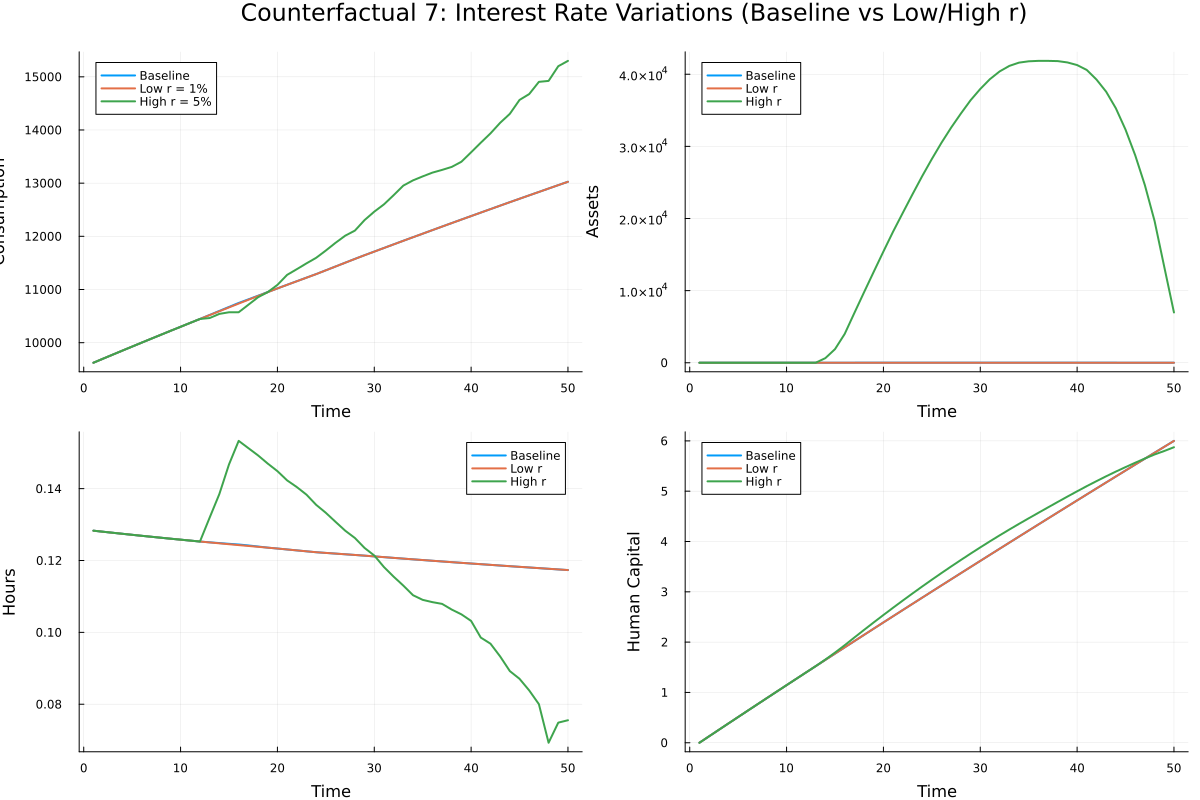

In [ ]:
# ----------------------------------------------
# 7. Interest Rate Variations (Low and High r)
# ----------------------------------------------

# Extract simulated series
low_r  = extract_all(model_low_r)
high_r = extract_all(model_high_r)

# Plot: Consumption
pr1 = plot(t, base.c, label="Baseline", lw=2, xlabel="Time", ylabel="Consumption")
plot!(t, low_r.c, label="Low r = 1%", lw=2)
plot!(t, high_r.c, label="High r = 5%", lw=2)

# Plot: Assets
pr2 = plot(t, base.a, label="Baseline", lw=2, xlabel="Time", ylabel="Assets")
plot!(t, low_r.a, label="Low r", lw=2)
plot!(t, high_r.a, label="High r", lw=2)

# Plot: Labor hours
pr3 = plot(t, base.h, label="Baseline", lw=2, xlabel="Time", ylabel="Hours")
plot!(t, low_r.h, label="Low r", lw=2)
plot!(t, high_r.h, label="High r", lw=2)

# Plot: Capital
pr4 = plot(t, base.k, label="Baseline", lw=2, xlabel="Time", ylabel="Human Capital")
plot!(t, low_r.k, label="Low r", lw=2)
plot!(t, high_r.k, label="High r", lw=2)

# Combine plots
plot(pr1, pr2, pr3, pr4,
     layout = (2, 2),
     size = (1200, 800),
     plot_title = "Counterfactual 7: Interest Rate Variations (Baseline vs Low/High r)",
     titlefont = 16, margin=3mm)

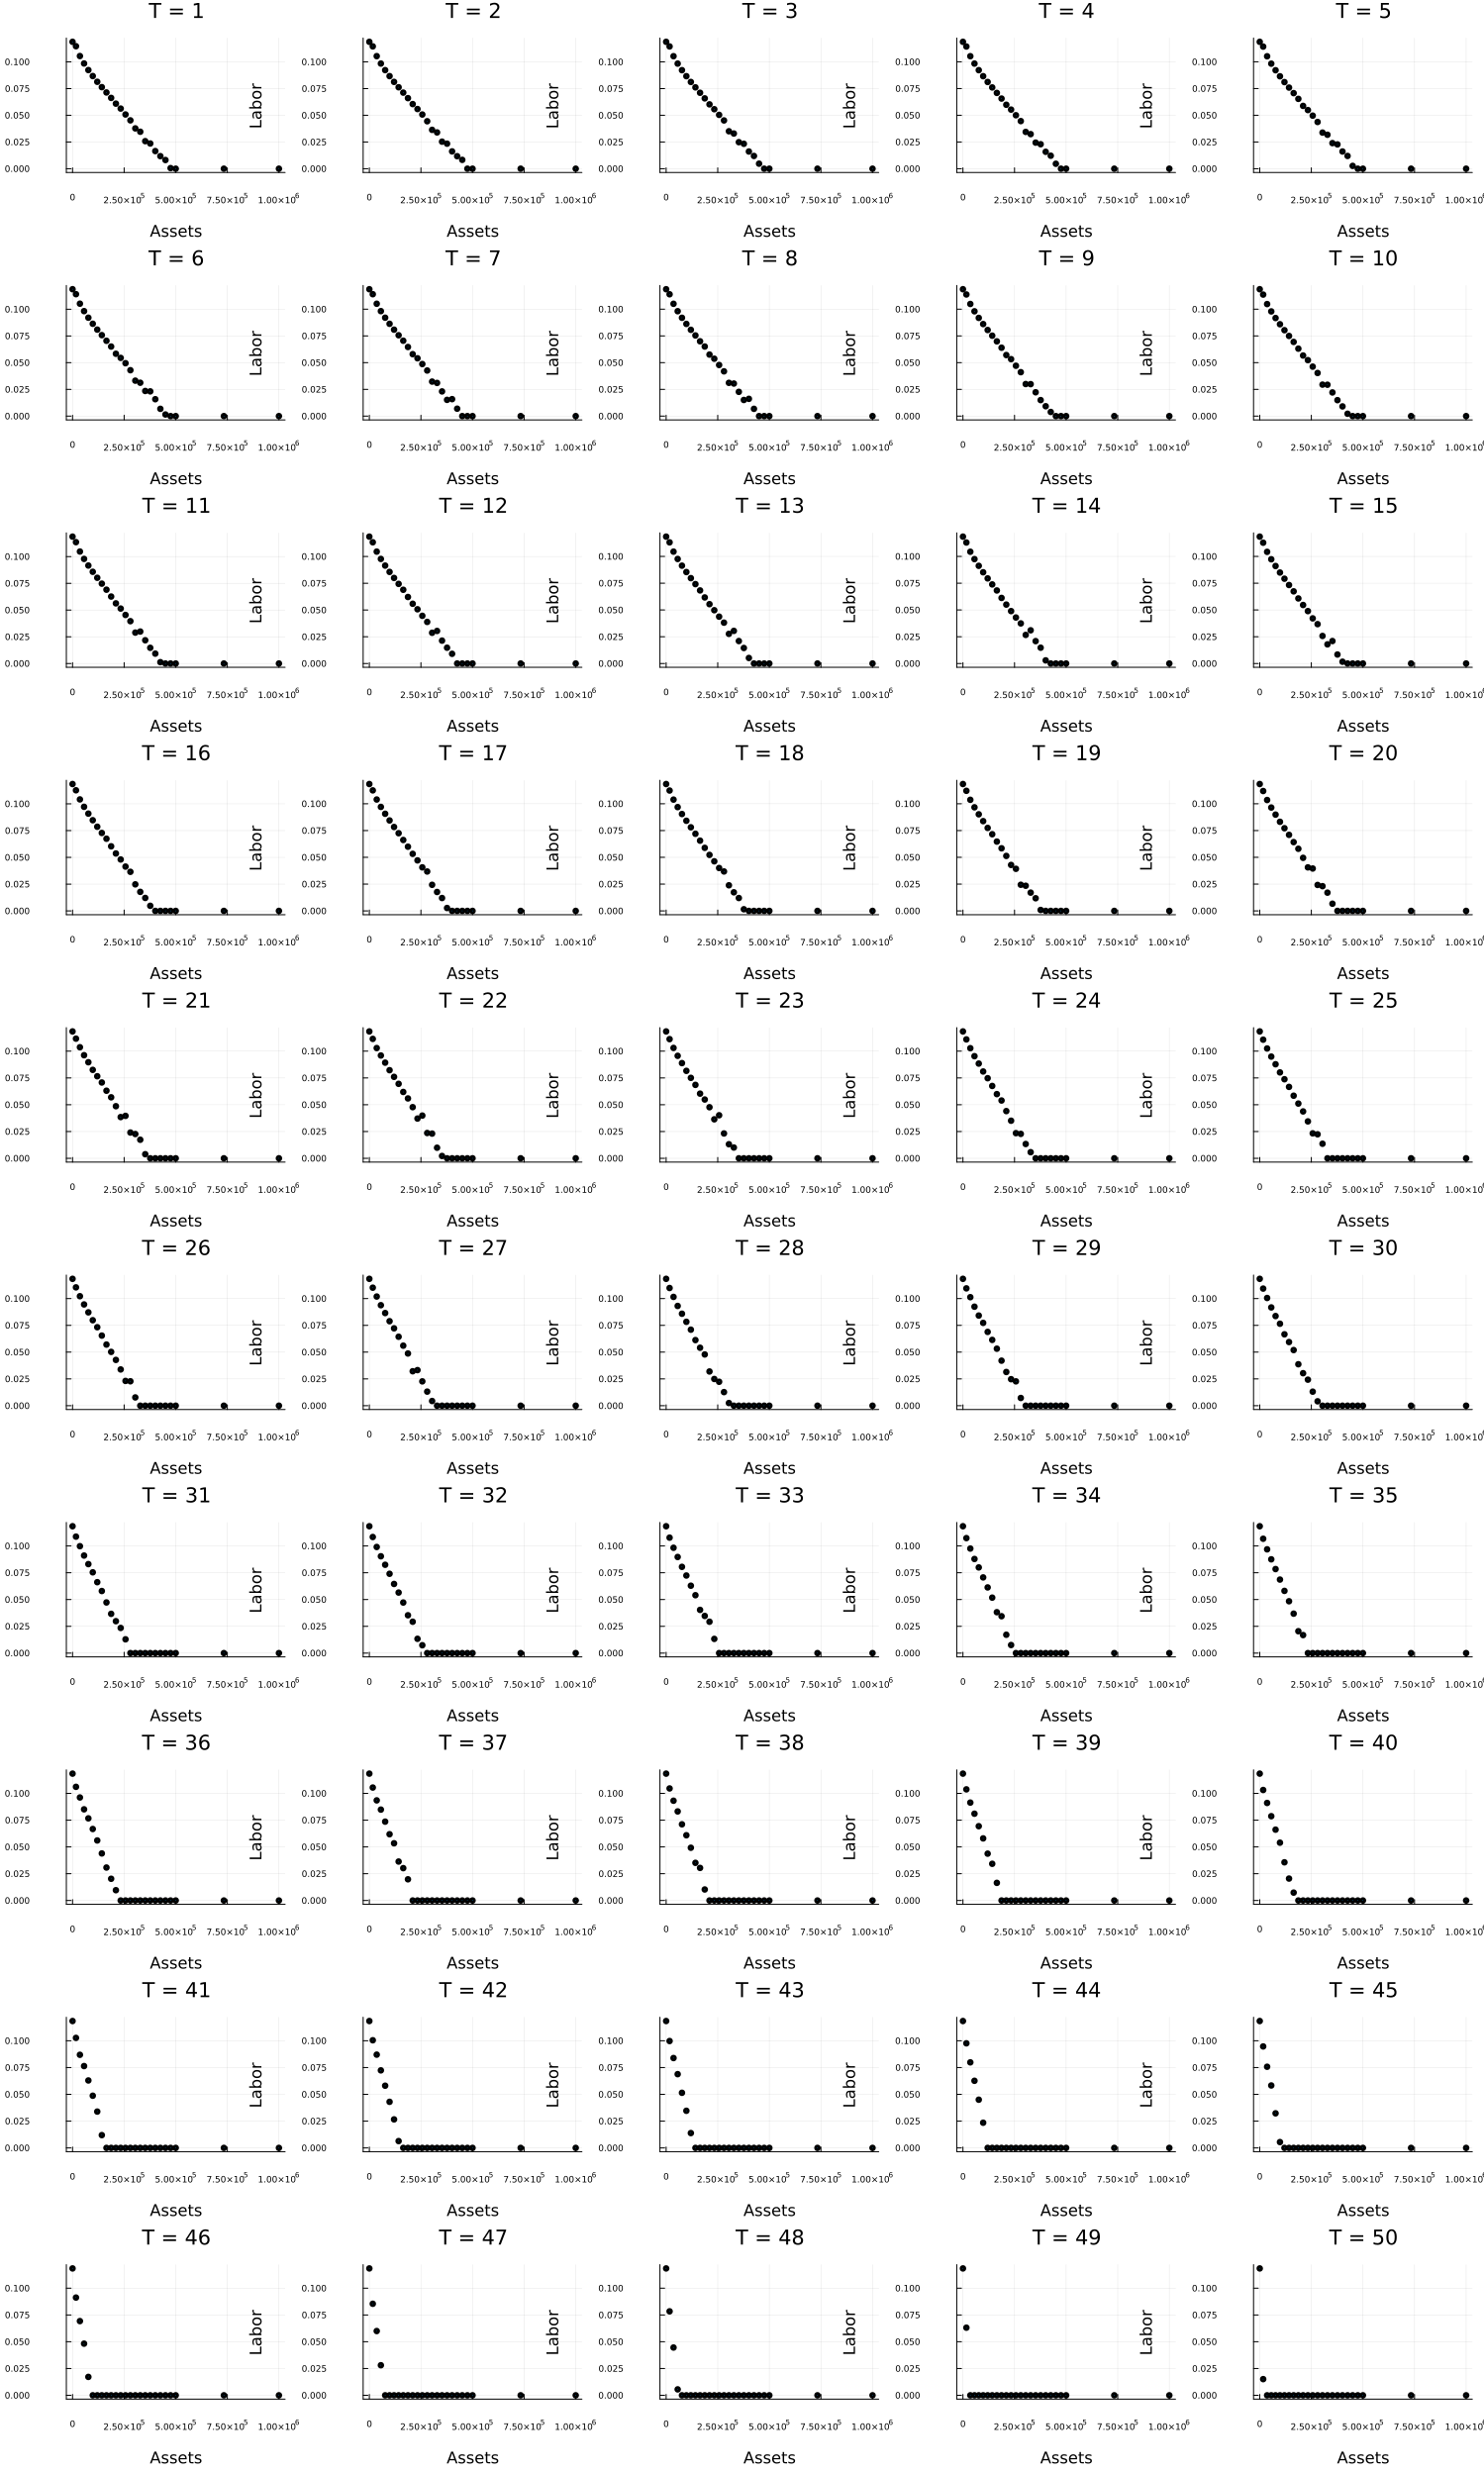

In [124]:
# visiualize the labor supply policy function for all the periods to see how it changes over time
gr()  # or your preferred backend

a_grid = model_baseline.a_grid
sol_h = model_baseline.sol_h
T = model_baseline.T
k_mid = Int(ceil(length(model_baseline.k_grid) / 2))  # pick a representative labor/skill state

plots = []

for t in 1:T
    p = scatter(a_grid, sol_h[t, :, k_mid],
        xlabel = "Assets",
        ylabel = "Labor",
        title = "T = $t",
        label = false,
        markersize = 2,
        tickfontsize=6)
    push!(plots, p)
end

# Layout: adjust number of columns depending on how many you want per row
ncols = 5
plot(plots..., layout = (ceil(Int, T / ncols), ncols), size = (300 * ncols, 250 * ceil(Int, T / ncols)))